# Society-based Cooperation - EVAC Assessment 2

## Design - Agent Representation

To begin with, each agent needs to be able to encode and store an evolvable strategy.

When defining an agents memory, there are $n^{2m}$ possible cases, where n is the number of different society types, and m is the number of games each agent is allowed to remember. In this proposed solution, each agent will have a memory of 1 match, therefore there are $4^2=16$ possibilities.

The encoded strategy is simply a rule which specifies the action the agent should take in each of these 16 cases. In the context of this problem, the action to take is the society the agent should switch to after a round has taken place.

 An example subsection of this strategy is shown in the table below. 

| Memory              | Strategy (Society to switch to)       |
| ------------------  | ------------------------------------  |
| (Saint, Saint)      | Buddy                                 |
| (Saint, Buddy)      | Vandal                                |
| (Saint, Fight Club) | Saint                                 |
| (Saint, Vandal)     | Saint                                 |
| ...                 | ...                                   |
| (Vandal, Vandal)    | Fight Club                            |


This strategy can be expressed compactly as a list of length $4^2$ (e.g. `[Buddy, Vandal, Saint, Saint, ..., Fight Club]`). Therefore each agent must be able to find the index for the chromosome from the match pairing it remembers.

Rather than generating a lookup table which maps society pairings to chromosome indexes, e.g. `{(Saint, Saint) = 0, (Saint, Buddy) = 1, ... (Vandal, Vandal) = 15}`, a faster method which also uses less memory is to map each society to a number between 0 and 3 and use the base 4 integer value of the pairing to access the chromosome. For example, with the assignments `{Saints: 0, Buddies: 1, Fight Club: 2, Vandals: 3}` the following indexes are obtained.

- (Saint, Saint) = $00_4$ maps to index 0
- (Saint, Buddy) = $01_4$ maps to index 1
- (Saint, Fight Club) = $02_4$ maps to index 2
- ...
- (Vandal, Vandal) = $33_4$ maps to index 15

**Summary**

To summarize, each agent will have a memory of 1 match which is stored as a pairing of the agents current faction and the opponent's faction. The base 4 representation of this matching will be used as the index to access the agents chromosome/strategy. This strategy is represented as list of length 16 where each gene represents the society to switch to. 


## Code - Setup
The following code imports any libraries needed to run the genetic algorithm, including the Distributed Evolutionary Algorithms in Python (DEAP) library which is an evolutionary computation framework allowing for rapid prototyping and testing of ideas. 

NumPy, Matplotlib & SciPy are used for statistical analysis and visualisation of the genetic algorithms performance.

A seed has been set for the random module, to ensure the submitted PDF matches the provided Colab notebook.

An Enum for the societies has also been defined so they can be easily referenced throughout the program. Each one is assigned a string value between 0 to 3 due to the explanation provided in **Design - Agent Representation**.

In [5]:
%pip install deap
%pip install tabulate

In [6]:
import random
import time

from deap import creator, base, tools
from collections import Counter
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tabulate import tabulate

from scipy.stats import chi2_contingency, mannwhitneyu

IND_SIZE = 4**2

random.seed(100)

class Society(Enum):
    """ Enum which represents all possible societies that agents can join"""
    SAINTS = "0"
    BUDDIES = "1"
    FIGHT_CLUB = "2"
    VANDALS = "3"

Matplotlib is building the font cache; this may take a moment.


## Code - The Game
The following code is used for the main game logic. This plays a round, determines the outcomes and updates the agents as required. 

In [7]:
# Dictionary which maps society pairings to their respective payoff amounts. 
OUTCOMES = {
    # Saints cooperate with everyone
    (Society.SAINTS, Society.SAINTS):           (4,4), # Both cooperate
    (Society.SAINTS, Society.BUDDIES):          (0,6), # Buddies are selfish
    (Society.SAINTS, Society.FIGHT_CLUB):       (4,4), # Both cooperate
    (Society.SAINTS, Society.VANDALS):          (0,6), # Vandals are selfish

    # Buddies only cooperate with each other
    (Society.BUDDIES, Society.SAINTS):          (6,0), # Buddies are selfish
    (Society.BUDDIES, Society.BUDDIES):         (4,4), # Both cooperate
    (Society.BUDDIES, Society.FIGHT_CLUB):      (6,0), # Buddies are selfish
    (Society.BUDDIES, Society.VANDALS):         (1,1), # Both selfish
    
    # Fight club cooperate with everyone but themselves
    (Society.FIGHT_CLUB, Society.SAINTS):       (4,4), # Both cooperate
    (Society.FIGHT_CLUB, Society.BUDDIES):      (0,6), # Buddies are selfish
    (Society.FIGHT_CLUB, Society.FIGHT_CLUB):   (1,1), # Both selfish
    (Society.FIGHT_CLUB, Society.VANDALS):      (0,6), # Vandals are selfish
    
    # Vandals cooperate with no one
    (Society.VANDALS, Society.SAINTS):          (6,0), # Vandals are selfish
    (Society.VANDALS, Society.BUDDIES):         (1,1), # Both selfish
    (Society.VANDALS, Society.FIGHT_CLUB):      (6,0), # Vandals are selfish
    (Society.VANDALS, Society.VANDALS):         (1,1), # Both selfish
}

def play_round(indiv1, indiv2, adaptive=True):
    '''Updates each individual depending on the outcome of the round played'''

    # Increments each individuals rounds_played attribute
    indiv1.rounds_played += 1
    indiv2.rounds_played += 1
    
    # Increases each individuals wealth by the appropriate payoff
    payoffs = OUTCOMES[(indiv1.society, indiv2.society)]
    indiv1.total_score += payoffs[0]
    indiv2.total_score += payoffs[1]

    if adaptive:
        # Queries each agents chromosome using base 4 representations of the match to decide what society to switch to.
        new_match = str(indiv1.society.value)+(indiv2.society.value)
        chr1_index = int(new_match, base=4)
        indiv1.society = Society(indiv1[chr1_index])
        chr2_index = int(new_match[::-1], base=4)
        indiv2.society = Society(indiv2[chr2_index])

## Design - Adaption & Evolution
Using the agent strategy representation discussed previously, the following genetic algorithm has been proposed to evolve this representation to maximize the agents total payoff over the course of the game.

### Population Generation
Firstly, a population needs to be generated. This is done by creating lists of length 16 and populating them randomly with societies. 

**The population size is set to 2000.**

### Evaluation & Fitness
For every generation of the algorithm, including the first population, the agents needs to be evaluated to determine their fitness. 

As discussed in the assessment brief, for $N$ rounds, two agents are randomly selected and play each other. Each time agents play each other, their `rounds_played` attribute is incremented by 1, their `total_score` is increased by the relevant payoff, and they both change society depending on their chromosomes value for that matchup of societies.

**The number of rounds $N$ is set to 10,000.**

Once the entire game is complete, the fitness for each agent needs to be calculated. As the game selects the agents who play each round completely randomly, there is likely to be an unfair difference between the total wealths of each agent. For example, an agent who has played 1 round and has a wealth of 6, should not have the same fitness as an agent who has played 6 rounds and also has a wealth of 6. 

Therefore, the fitness of each agent is defined by the agents total wealth divided by the number of rounds it has played, as shown below.

$fitness(agent) =  \frac{agent_{total\_score}}{agent_{rounds\_played}}$


### Selection

Once the fitnesses have been calculated for all agents, a new population needs to be selected. The method of selection used is tournament selection. This selects a specified number of agents and takes the one with the highest fitness value from the tournament and adds it to the new population. **The tournament size is set to  20**. A diagram showing this method of selection is provided below.

![](https://drive.google.com/uc?export=view&id=1FQq7L4n7Beqctz3VUxmsNTPLjiBOgqty)

### Crossover
Crossover is then performed on the selected agents. The method of crossover selected is two point crossover where two points are picked randomly from the parent chromosomes and the societies in between the two points are swapped. **The probability of this crossover occurring per agent is set to 0.15.** A diagram of this method of crossover is provided below. 

![](https://drive.google.com/uc?export=view&id=10_QyNSejbjT9i4f6d5Wul6wVCJSrqVo_)

### Mutation
Mutation is then performed on the agents produced by the crossover step. The method of mutation chosen is the shuffle indexes method, where if a gene is chosen to be mutated, it is swapped with a random gene elsewhere in the chromosome. **The probability of this mutation occurring per gene is set to 0.05.** An example of this mutation is provided in the diagram below.

![](https://drive.google.com/uc?export=view&id=1rjOvEjyq1PVgaDTiKrO6Gyr2F5ruja6y)

### Population Reset & Re-evaluation
As the agents chromosomes have been changed, their attributes must be reset and their fitnesses re-evaluated using the method described previously. This process then occurs for a defined number of generations. **The number of generations has been set to 200.** A flowchart showing the overall design of the procedure is provided below. 

![](https://drive.google.com/uc?export=view&id=1RY0opP4HWg29kmJODtU9q25XB4-jDU_L)



## Code - Adaption & Evolution
The following code implements the design mentioned previously.

### Execution time
No hardware acceleration has been used to gain the following execution times.

- Locally on own device - Approx. 30 seconds
- Google Colab - Approx. 70 seconds



In [8]:
def reset_population(population):
    '''Resets all agent's attributes prior to evaluation'''
    for indiv in population:
        indiv.total_score = 0
        indiv.rounds_played = 0
        indiv.society = random.choice(list(Society))
        indiv.history = "".join([random.choice([society.value for society in Society]) for i in range(2)])

def evaluate_agents(population, num_rounds):
    '''Runs the game and sets each agents fitness depending on the outcome'''
    for i in range(num_rounds):
        indiv1 = random.choice(population)
        indiv2 = random.choice(population)
        while indiv2 == indiv1:
            indiv2 = random.choice(population)
        play_round(indiv1, indiv2)
    
    for ind in population:
        if ind.rounds_played == 0:
            ind.fitness.values = 0,
        else:
            ind.fitness.values = ind.total_score / ind.rounds_played,

def run_GA(gen_num=200, pop_num=2000, round_num=10000, mut_prob=0.05, cx_prob=0.15, tourn_size=200):
    '''Runs the genetic algorithm and returns the statistics from the run'''

    print("-- GENETIC ALGORITHM -- ")
    start_time = time.time()

    # Sets the fitness to maximise as each agent wants to maximise its income
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))

    # Defines class for each Individual with the chromosome as a list and fitness as maximizing. Also defines the attributes each agent will require. 
    creator.create("Individual", list, fitness=creator.FitnessMax, total_score=0, rounds_played=0, society=Society.SAINTS, history = "00")

    toolbox = base.Toolbox()

    # Registers function to create a gene with the value "0", "1", "2", "3" to represent each society.
    toolbox.register("attr_str", random.choice, [society.value for society in Society])

    # Registers function which creates an Individual with 16 random genes.
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_str, n = 16)

    # Registers function to select, crossover and mutate individuals
    toolbox.register("select", tools.selTournament, tournsize=tourn_size)
    toolbox.register("crossover", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=mut_prob)

    # Registers the function to create a population as a list of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Regisers the manually created functions to evaluate and reset the population
    toolbox.register("evaluate", evaluate_agents)
    toolbox.register("reset_population", reset_population)

    # Registers the statistics & logbook that will be logged during the GA
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("mean", np.mean)
    stats.register("std", np.std)
    stats.register("median", np.median)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()

    # Creates initial population
    population = toolbox.population(pop_num)

    # Resets population to prevent bias as deap creates all agents with same society and history attributes. 
    toolbox.reset_population(population)

    # Evaluates the initial population
    toolbox.evaluate(population, round_num)

    # Initializes dictionary to count number of agent per society in each generation
    counts = {
        Society.SAINTS: [],
        Society.BUDDIES: [],
        Society.FIGHT_CLUB: [],
        Society.VANDALS: []
    }

    for g in range(gen_num):
        print(f"-- Running Generation {g+1}/{gen_num} --       ", end='\r')

        # Selects new population and clones all individuals due to duplicates.
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Performs crossover on 2 individuals based on crossover probability
        for indiv1, indiv2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.crossover(indiv1, indiv2)

        # Mutates offspring based on mutation probability
        for mutant in offspring:
            toolbox.mutate(mutant)
        
        # Resets agent attributes and fitness values
        toolbox.reset_population(offspring)

        # Recalculates fitness values for mutated offspring
        toolbox.evaluate(offspring, round_num)

        # Replaces old population with new mutated offspring
        population[:] = offspring

        # Compiles & records the statistics for the new generation
        record = stats.compile(population)
        logbook.record(gen=g, **record)
        assignments = [indiv.society for indiv in population]
        for society in Society:
            counts[society].append(assignments.count(society))
    
    print(f"\nExecution Time - {time.time()-start_time:.2f}s")

    return logbook, counts, [agent.fitness.values[0] for agent in population]


## Design - Evaluation Procedure
The genetic algorithm will be evaluated in a variety of ways as described below.

### Overall Run
Two graphs will be produced to show the effect of the genetic algorithm over the generations. The first graph will show the mean fitness of the agents within the population and the second will show the number of agents per society, throughout the generations. This will hopefully show that as the adaption takes place, over time the agents will achieve higher scores and therefore higher fitnesses. The second graph may help to illustrate the strategy that the agents are following which provide the higher fitness values.

The final generation of the genetic algorithm that uses adaptive techniques, will be compared with a population who do not adapt to their environment and therefore do not switch society after each round. The following comparisons will be used.

### Chi-Squared Test - Comparison with Non-Adaptive Version

Firstly, the 'Chi-Squared Test of Independence' will be used. This will determine if there is a significant relationship between the populations, adaptive & non-adaptive, and the frequencies of each society. The null hypothesis & alternative hypothesis for this is as follows.

> $H_0$ The type of intervention, non-adaptive or adaptive, has no affect on the number of agents per society.

> $H_A$ The type of intervention, non-adaptive or adaptive, has a statistically significant affect on the number of agents per society.

### Mann–Whitney U Test - Comparison with Non-Adaptive Version

The 'Mann-Whitney U' test will then be used to test the fitnesses of each population and determine if the difference between them is due to random sampling or if the populations are distinct. The Mann-Whitney U test is a nonparametric test and therefore allows the two population's fitnesses to be compared without making the assumption that the fitnesses are normally distributed. The null hypothesis & alternative hypothesis for this is as follows.

> $H_0$: The two populations of agents, non-adaptive and adaptive, have the same distribution of fitnesses.
 
> $H_A$: The two populations of agents, non-adaptive and adaptive, have different distribution of fitnesses. 

### Box-Plot Analysis - Comparison with Non-Adaptive Version

The distributions of the final fitness values will also be manually compared using box plots.



## Code - Evaluation Procedure 
The following code is used to perform the evaluation procedure.

In [9]:
class NonAdaptiveAgent:
    '''Represents an agent who cannot change their society after each round'''
    def __init__(self):
        self.society = random.choice(list(Society))
        self.total_score = 0
        self.rounds_played = 0
    
    def fitness(self):
        if self.rounds_played == 0:
            return 0
        else:
            return self.total_score / self.rounds_played


def run_non_adaptive_sim(pop_num=2000, round_num=10000):
    '''Runs the game using non-adaptive agents and returns the fitnesses and number of agents per society'''
    agents = [NonAdaptiveAgent() for _ in range(pop_num)] # Initializes the population

    for _ in range(round_num):
        # Randomly selects two agents per round to play each other
        indiv1 = random.choice(agents)
        indiv2 = random.choice(agents)
        while indiv2 == indiv1:
            indiv2 = random.choice(agents)
        # Plays a single round and updates each agents score and round attributes
        play_round(indiv1, indiv2, adaptive=False)
    
    fitnesses = [agent.fitness() for agent in agents]
    counts = Counter([agent.society for agent in agents])
    return fitnesses, counts
    

def draw_genetic_graphs(logbook, counts):
    ''' Draws the two graphs to show average fitness and number of agents per society over the generations.'''
    plt.style.use('dark_background')
    plt.style.use('bmh')

    # Extracts required information from deap logbook
    gens = logbook.select("gen")
    means = logbook.select("mean")

    # Initialises figure
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(22, 10)
    ax1.margins(0.03)

    # Draws mean fitness graph
    ax1.set_title("Mean Fitness of Agents per Generation", fontsize=18)
    ax1.set_xlabel('Generations' , fontsize=14)
    ax1.set_ylabel('Mean Fitness' , fontsize=14)
    ax1.plot(gens, means, lw=2, color="#0D94D7")

    # Draws number of agents per society graph
    ax2.margins(0.03)
    ax2.set_title("Society Assignment Frequencies per Generation", fontsize=18)
    ax2.set_xlabel('Generations' , fontsize=14)
    ax2.set_ylabel('Society Assignment Counts' , fontsize=14)
    ax2.plot(gens, counts[Society.SAINTS], lw=2, color="#0094FF", label="Saints")
    ax2.plot(gens, counts[Society.BUDDIES], lw=2, color="#9000FF", label="Buddies")
    ax2.plot(gens, counts[Society.FIGHT_CLUB], lw=2, color="#07DD79", label="Fight Club")
    ax2.plot(gens, counts[Society.VANDALS], lw=2, color="#DB1B1B", label="Vandals")
    
    legend = plt.legend()
    plt.setp(legend.get_texts(), color='black')
    plt.show()

def draw_comparison_boxplots(nonadaptive_fits, adaptive_fits):
    '''Draws a box plot of the distribution of the fitnesses from the final generation of the 
        adaptive algorithm vs the fitnesses from the non-adaptive game.'''
    plt.style.use('dark_background')
    plt.style.use('bmh')

    # Initializes figure
    fig, ax = plt.subplots()
    ax.set_title("Distribution of adaptive agent fitnesses from the final generation against non-adaptive agents", fontsize=18)
    fig.set_size_inches(20, 7.5)

    # Draws box plots
    labels = ["Non-Adaptive", "Adaptive"]
    data = [nonadaptive_fits, adaptive_fits]
    ax.set_xlabel('Fitness (Score / Rounds Played)', fontsize=14)
    ax.set_ylabel('Algorithm Type', fontsize=14)
    outlier_formatting = {"marker":'o', "markerfacecolor":'black', "markersize":5, "linestyle":"none"}
    median_formatting = {"color": "black", "linewidth": 4}
    box_plot = ax.boxplot(data, vert=False, patch_artist=True,labels=labels,
     medianprops=median_formatting, flierprops=outlier_formatting, widths=0.5)
    
    # Sets colour formatting of the box plots
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(box_plot[element], color="black")
    colours = ["#07DD79", "#DB1B1B"]
    for patch, color in zip(box_plot['boxes'], colours):
        patch.set_facecolor(color)

def chi_squared(non_adaptive_counts, adaptive_counts):
    '''Runs the chi squared test of independence on the agent counts per society 
        from the adaptive run and non-adaptive run'''

    # Creates the continency table
    non_adaptive = [non_adaptive_counts[society] for society in list(Society)]
    adaptive = [adaptive_counts[society][-1] for society in list(Society)]
    observed = [non_adaptive, adaptive]

    chi2, p, dof, expected = chi2_contingency(observed)
    
    return p, observed, expected.tolist(), chi2, dof

def print_chi_squared(p, observed, expected, chi2, dof):
    '''Prints output of chi squared test'''

    # Manually adds row headers to the lists
    obs_val_r_headers = [["Non-Adaptive"] + observed[0], ["Adaptive"] + observed[1]]
    exp_val_r_header = [["Non-Adaptive"] + expected[0], ["Adaptive"] + expected[1]]

    # Creates col headers
    col_headers = [""]  + [society.name.capitalize() for society in list(Society)]

    # Prints outputs
    print("                         Observed Values                          ")
    print(tabulate(obs_val_r_headers, col_headers, tablefmt="fancy_grid"))
    print("                         Expected Values                          ")
    print(tabulate(exp_val_r_header, col_headers, tablefmt="fancy_grid"))
    print(f"Test Statistic={chi2:.2f}, p={float('%.1g' % p)}, Degrees of Freedom={dof}")

def mann_whittney_u(non_adaptive_fitnesses, adaptive_fitnesses):
    '''Calculates the U and p value for the two fitness distributions'''

    na_size = len(non_adaptive_fitnesses)
    a_size = len(adaptive_fitnesses)
    max_u_size = na_size * a_size

    U, p = mannwhitneyu(non_adaptive_fitnesses, adaptive_fitnesses)
    return U, p, na_size, a_size, max_u_size

def print_mwu(U, p, na_size, a_size, max_u_size):
    '''Prints output of Mann Whitney U test'''
    print("----------------------------------------------")
    print(f"U (Non-Adaptive)={U: .1f}")
    print(f"'U (Adaptive)={max_u_size - U: .3f}")
    print(f"p={float('%.1g' % p)}")
    print(f"Sample sizes: {a_size} & {na_size}")
    print(f"Max U value= {max_u_size}")
    print("----------------------------------------------")
	

In [10]:
logbook, adaptive_counts, adaptive_fitnesses = run_GA(gen_num=200, pop_num=2000, round_num=10000, mut_prob=0.05, cx_prob=0.15, tourn_size=20)
non_adaptive_fitnesses, non_adaptive_counts = run_non_adaptive_sim()

-- GENETIC ALGORITHM -- 
-- Running Generation 200/200 --       
Execution Time - 11.73s


## Results - Evaluation Procedure

### Overall Run
The two graphs produced from the overall run of the genetic algorithm are shown below

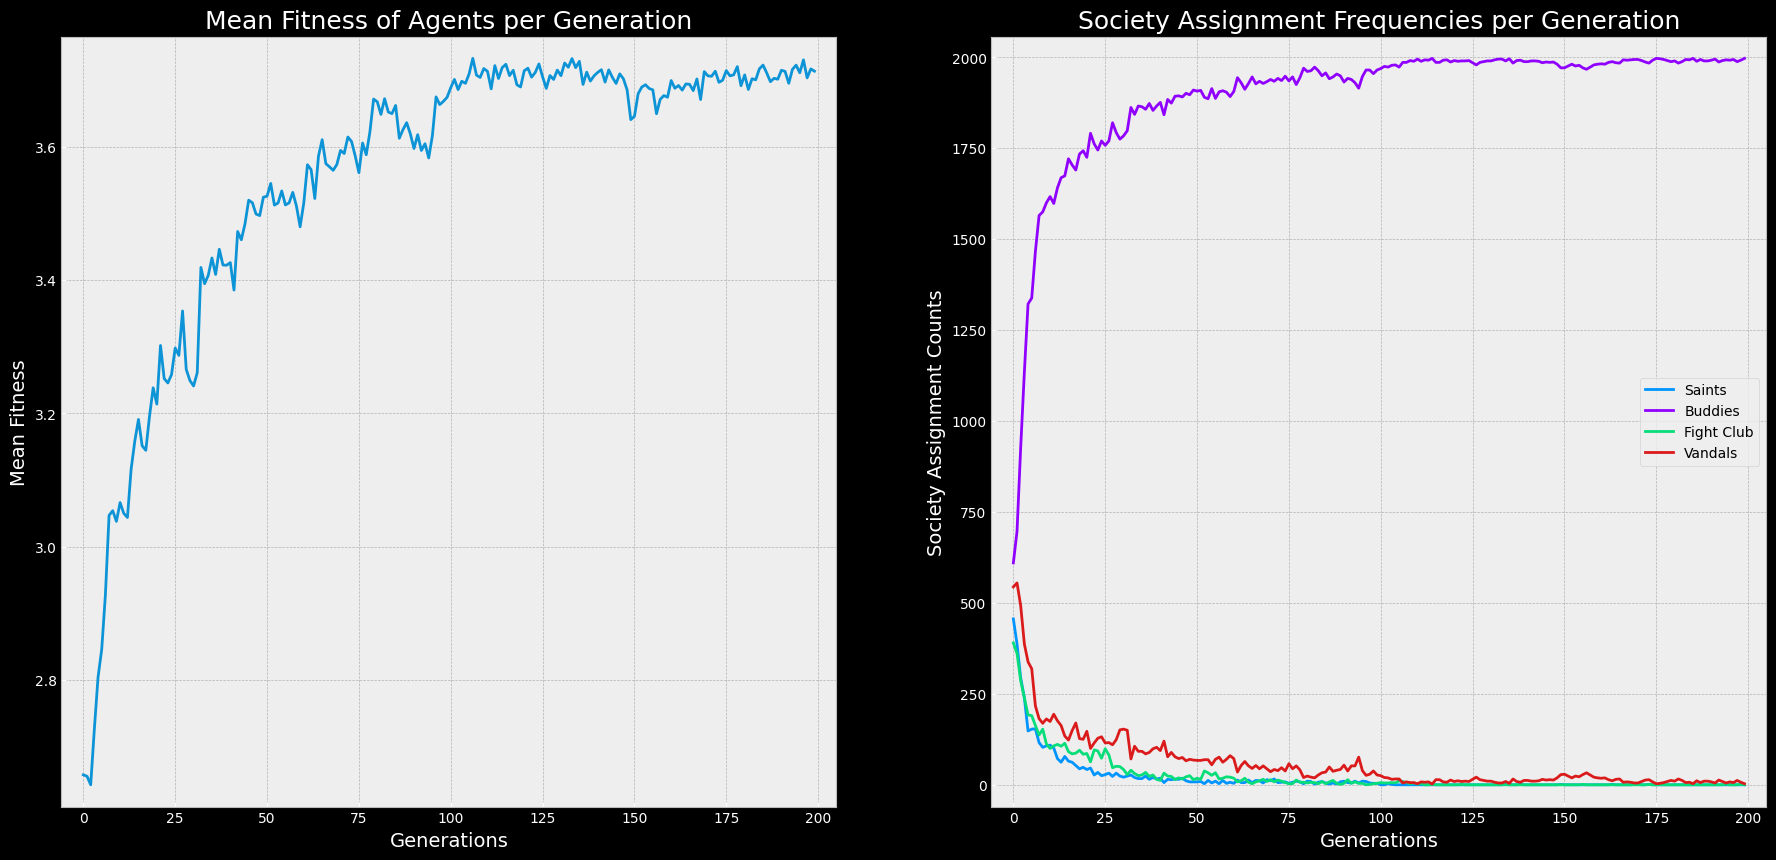

In [11]:
draw_genetic_graphs(logbook, adaptive_counts)

The first graph shows that the average fitness of the population significantly increases in the first 100 generations, until it stabalizes at around 3.7.

The second graph seems to suggest that this increase in fitness is related to the increased number of buddies in the population.

### Chi-Squared Test - Comparison with Non-Adaptive Version

The output of the Chi-Squared Test is shown below. 

In [12]:
print_chi_squared(*chi_squared(non_adaptive_counts, adaptive_counts))

                         Observed Values                          
╒══════════════╤══════════╤═══════════╤══════════════╤═══════════╕
│              │   Saints │   Buddies │   Fight_club │   Vandals │
╞══════════════╪══════════╪═══════════╪══════════════╪═══════════╡
│ Non-Adaptive │      505 │       505 │          487 │       503 │
├──────────────┼──────────┼───────────┼──────────────┼───────────┤
│ Adaptive     │        0 │      1997 │            0 │         3 │
╘══════════════╧══════════╧═══════════╧══════════════╧═══════════╛
                         Expected Values                          
╒══════════════╤══════════╤═══════════╤══════════════╤═══════════╕
│              │   Saints │   Buddies │   Fight_club │   Vandals │
╞══════════════╪══════════╪═══════════╪══════════════╪═══════════╡
│ Non-Adaptive │    252.5 │      1251 │        243.5 │       253 │
├──────────────┼──────────┼───────────┼──────────────┼───────────┤
│ Adaptive     │    252.5 │      1251 │        243.5 │       2

As the p value is <= 0.05, the null hypothesis is rejected, therefore the intervention (adaptive algorithm) has a statistically significant effect on the number of agents per society (at 95% confidence level). Therefore we can assume that the adaptive algorithm has formed a strategy for switching societies that is different to random assignment. 

### Mann–Whitney U Test - Comparison with Non-Adaptive Version

The output of the Mann-Whitney U Test is shown below. 

In [13]:
print_mwu(*mann_whittney_u(non_adaptive_fitnesses, adaptive_fitnesses))

----------------------------------------------
U (Non-Adaptive)= 1184996.0
'U (Adaptive)= 2815004.000
p=2e-110
Sample sizes: 2000 & 2000
Max U value= 4000000
----------------------------------------------


As the Mann-Whitney U test gives an extremely small value p value, it means that we can again reject the null hypothesis and determine that the two populations have different distributions.

If the null hypothesis was true, then the U value should be approximately half of the maximum U value of 4 million. However, its value of 1,184,996 shows that it is significantly lower. Therefore, it is likely that the adaptive algorithm with the U' value of 2815004, produces higher fitnesses.

## Box-Plot Analysis - Comparison with Non-Adaptive Version
 
The output of the Box-Plot analysis is shown below.

/var/folders/rn/bknbys_16y56pmzqgbzgt8n80000gq/T/ipykernel_68466/2842701945.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(data, vert=False, patch_artist=True,labels=labels,


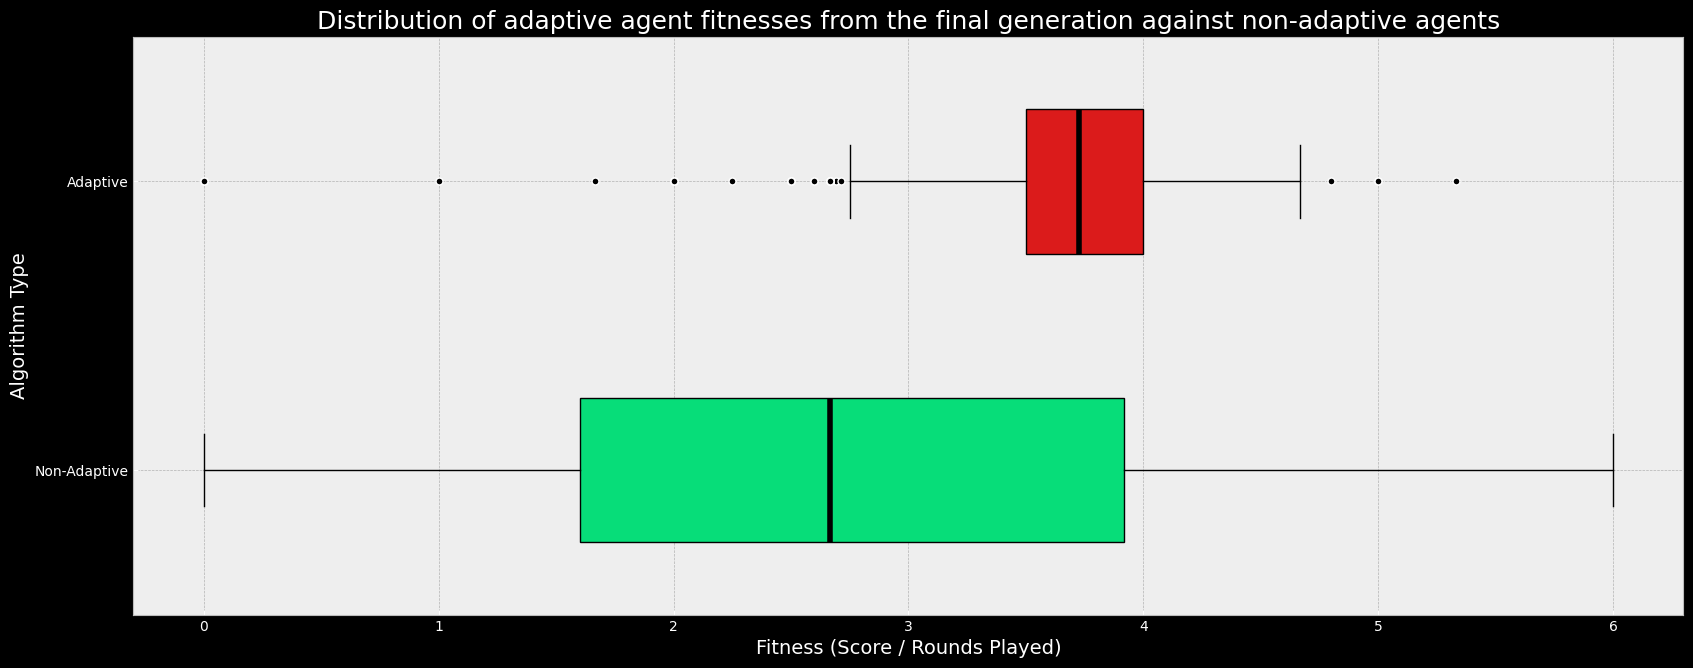

In [14]:
draw_comparison_boxplots(adaptive_fits=adaptive_fitnesses, nonadaptive_fits=non_adaptive_fitnesses)

As you can see by the above box plots, the adaptive version has a much higher median fitness, supported by the outcome of the Mann-Whitney U test. This means on average the adaptive agents had higher average scores.

The length of the box for the adaptive version is also much smaller in comparison to the non-adaptive, and the range for non-adaptive is very large, showing that the non-adaptive version's fitnesses are significantly spread out.

### Conclusion

To conclude, the adaptive behavior seems to provide more agents who achieve higher scores by the end of the game. 

The strategy that develops is that the population converges to buddies over the generations, which was shown in the graph showing the agents society assignments overtime. This was supported by the chi squared independence test which showed the adaptive behavior statistically significantly affected the frequencies of agents per society by the end of the game. 

Using the adaptive behavior, each agents average score per round is approximately around 4, as buddies always cooperate with each other. This is shown by the fitness graph over the generations and in the final box plot. Any differences in this are likely caused by the mutation that occurred after selection in the final generation.

While it is possible for lucky agents to achieve higher scores when using non-adaptive behavior, due to the fact they can win games and achieve scores of 6, this is based on randomness. Whereas with the adaptive behavior, as the entire population converges, each agent is almost always guaranteed a score of 4 in each round, which is why the mean and median results are higher for the adaptive behavior. 